# Time series forecasting with ARIMA (Autoregressive Integrated Moving Average)

## Introduction
Using New York City Uber pickups data, we will forecast future trip volume.

## Basic
### Part 1: Data Exploration

1. Load the data from `data/uber.zip` and store it as a pandas Series called `rides`. The data
consists of timestamps for when customers are picked up, so set the appropriate arguments to
convert these values into a datetime format like so (what do the arguments do?):

```python
import pandas as pd
rides = pd.read_csv(
    'data/uber-aprsep-14.csv.zip', squeeze=True, parse_dates=['date'])
```

In [25]:
import pandas as pd
rides = pd.read_csv(
    '../data/uber-aprsep-14.csv.zip', squeeze=True, parse_dates=['date'])

2. Create a pandas Series where the values are all 1 and the index are the timestamps that you
loaded using the following code:  

    ```python
    rides = pd.Series(1, index=rides)
    ```

    Your series should now look like this (where the left column is your index):

    ```
    >>> rides.head()
    date
    2014-04-01 00:11:00    1
    2014-04-01 00:17:00    1
    2014-04-01 00:21:00    1
    2014-04-01 00:28:00    1
    2014-04-01 00:33:00    1
    dtype: int64
    ```

In [26]:
import pandas as pd
rides = pd.read_csv('../data/uber-aprsep-14.csv.zip', squeeze=True, parse_dates=['date'])
rides = pd.Series(1, index=rides)
rides.head()

date
2014-04-01 00:11:00    1
2014-04-01 00:17:00    1
2014-04-01 00:21:00    1
2014-04-01 00:28:00    1
2014-04-01 00:33:00    1
dtype: int64

3. Convert the data to hourly ride counts. (Look at the [documentation][1] for the `resample`
method, particularly the Notes and Examples sections.)  
<br/>
<br/>
Your hourly data should look like this:

```
>>> rides_hourly.head()
date
2014-04-01 00:00:00    138
2014-04-01 01:00:00     66
2014-04-01 02:00:00     53
2014-04-01 03:00:00     93
2014-04-01 04:00:00    166
Freq: H, dtype: int64
```

<!-- Links -->
[1]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

In [27]:
rides_hourly = rides.resample('H').count()
rides_hourly.head()

date
2014-04-01 00:00:00    138
2014-04-01 01:00:00     66
2014-04-01 02:00:00     53
2014-04-01 03:00:00     93
2014-04-01 04:00:00    166
Freq: H, dtype: int64

4. Plot the hourly ride counts. Comment on the presence of trends, seasonality and cycles. You can
zoom in on smaller time periods if the data is too dense like so (set your own start and end dates):

```python
rides_hourly['2014-04-01':'2014-09-30']
```

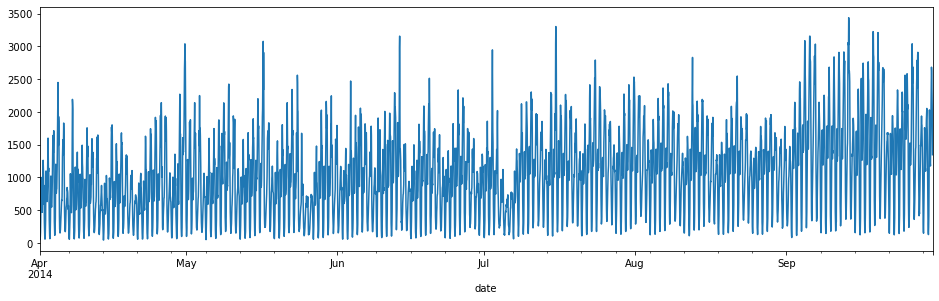

In [28]:
_ = rides_hourly.plot(figsize=(16, 4.5))

*Hourly ride counts have an increasing trend.*  
*Hourly ride counts have seasonality. The pattern of rising and falling counts repeats every day.*  
*Ride counts also regularly increase and decrease across the days of the week.*  

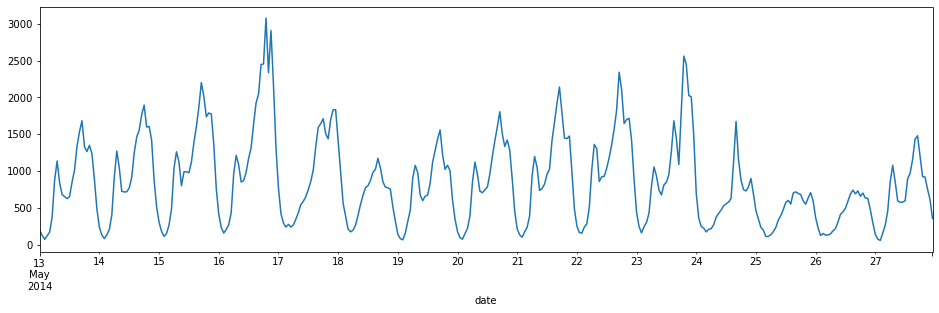

In [29]:
_ = rides_hourly['2014-05-13':'2014-05-27'].plot(figsize=(16, 4.5))

5. Seasonal subseries plots are another way to visualize time series data, where the data for each
'season' are plotted as their own series. It can help detect seasonality in data for a selected
periodicity. Below are seasonal subseries plots for hourly and daily rides. Comment on the presence
of trends, seasonality and cycles.

<div align='center'>
    <img src='../images/hourly-subseries.png'/>
</div>

*Hourly ride counts have an increasing trend that was hard to detect by visualizing the raw
series.*  
*Hourly ride counts have seasonality. The pattern of rising and falling counts repeats every day.*  
*Within a day, ride counts increase from a minimum in the early morning with a small peak during
the morning rush hour to a big peak during the evening rush hour before decreasing until the
next morning.*

<div align='center'>
    <img src='../images/daily-subseries.png'/>
</div>

*Daily ride counts have an increasing trend.*  
*Daily ride counts have seasonality. The pattern of rising and falling counts repeats every 7 days.*  
*Within a week, ride counts peak every Thursday and reach a low every Sunday.*

## Advanced
### Part 2: Box-Jenkins Method
We will follow the Box-Jenkins method to identify ARIMA models, starting with a non-seasonal ARIMA
model before tackling more complex seasonal ARIMA models (SARIMA).

<div align='center'>
    <img src='../images/box-jenkins-method.png' width=500/>
</div>

6.  Create a Series for **weekly** rides and plot it. Discard the final observation because it is
only a partial week. We can only use the Box-Jenkins method to identify patterns in stationary
data. Do you think this time series is stationary? Comment on the presence of trends, seasonality
and cycles, and on how the data varies with time.

*Weekly ride counts have an increasing trend.*  
*There is no seasonality.*  
*The variance may be higher in the second half of the time period, but it is hard to tell because
there are not many observations.*  
*The series is non-stationary because the mean changes with time (there is an increasing trend.)*

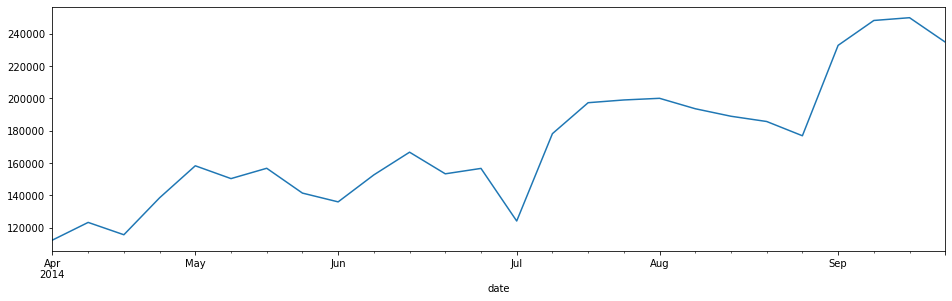

In [30]:
rides_weekly = rides.resample('W').count()[:-1]
_ = rides_weekly.plot(figsize=(16, 4.5))

7. When the series appears to have nonconstant variance (amount of variation depends on the level
of the series or particular periods of time), we can apply a mathematical transformation to try to
make the variance more constant.  

    A useful family of transformations is the Box-Cox transformations ([Box & Cox, 1964][2]), which
    transforms data using a parameter $\lambda$ as follows:

<div align='center'>
    <img src='../images/box-cox-1.png'>
</div>

<!--     $$
    y^{\left( \lambda \right)} = 
    \begin{cases}
        \frac{y^{\lambda} - 1}{\lambda} &(y \neq 0)\\
        \log y &(y = 0)
    \end{cases}
    $$ -->

    This is conceptually equivalent (**but not equivalent in implementation**) to:

<div align='center'>
    <img src='../images/box-cox-2.png'>
</div>

<!--     $$
    y^{\left( \lambda \right)} = 
    \begin{cases}
        y^{\lambda} &(y \neq 0)\\
        \log y &(y = 0)
    \end{cases}
    $$ -->

    So $\lambda$ can be interpreted as transforming the data by raising it to the power $\lambda$,
    or taking the natural log if $\lambda$ = 0.

    A Box-Cox transformation makes the distribution of the data more normal-like, which is the
    basis for determining confidence intervals for $\lambda$. Use the following code to find a 95%
    confidence interval for $\lambda$ using [scipy.stats.boxcox][3]. If 1 is in the confidence
    interval, the data does not need to be transformed. Why?

    ```python
    from scipy.stats import boxcox
    transformed, lmbda, ci = boxcox(rides_weekly, alpha=0.05)
    print(ci)
    ```

<!-- Links -->
[2]: http://www.econ.uiuc.edu/~econ536/Papers/boxcox64.pdf
[3]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

*The data do not need to be transformed because $y^{1}$ can plausibly produce the most
normal-looking data with a confidence level of 95%.*  
*We can interpret this result as suggesting that the data have constant variance.*  
*$\lambda$=0.5 (taking the square root), $\lambda$=0.33 (taking the cube root), $\lambda$=0 (taking
the natural log) and $\lambda$=-1 (taking the inverse) are other easily interpretable
transformations of the data that produce normal-looking data, but if the original data suffice, we
will not favor a transformation.*

In [31]:
from scipy.stats import boxcox
transformed, lmbda, ci = boxcox(rides_weekly, alpha=0.05)
print(ci)

(-1.8761688222135826, 1.5536833104511825)


8. In addition to visually inspecting the data, we can inspect the ACF plot of the data.
Non-stationary time series will have ACF plots that decrease slowly (exponential decay). However,
if the autocorrelation values decrease quickly, it does not necessarily mean the data is
stationary. Use the code below to create an ACF (autocorrelation function) plot of the data. Is the
data stationary?

```python
import statsmodels.api as sm
rides_weekly = rides.resample('W').count()[:-1]
_ = sm.graphics.tsa.plot_acf(rides_weekly)
```

*From inspecting the ACF plot, the data look non-stationary because the autocorrelation values
decay slowly (exponentially).*

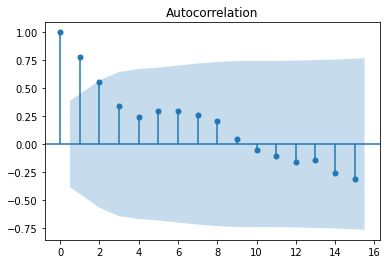

In [32]:
import statsmodels.api as sm
rides_weekly = rides.resample('W').count()[:-1]
_ = sm.graphics.tsa.plot_acf(rides_weekly)

9. We can also use statistical hypothesis tests to determine whether data are stationary. Two
popular tests are the augmented Dickey-Fuller (ADF) test and the Kwiatowski-Phillips-Schmidt-Shin
(KPSS) test. Be careful interpreting the results of the tests as the null hypothesis of the ADF
test is that a series is non-stationary but the null hypothesis of the KPSS test is the opposite,
that a series is stationary.  

    The ADF test is more widely known, but the KPSS test is the default in the R programming language's
`auto.arima` function of the `forecast` package, due to its [better real-world performance.][4]  

    Contrary to what you may see online, there is no reason to perform both tests on the same data.
They test for the same aspect of non-stationarity (presence of a unit root) and in practice,
[using the ADF test will lead to more differencing of the data than using the KPSS test.][4] Also,
performing both tests sometimes leads to contradictory results.  

    You can import the tests using the code below:

    ```python
    from statsmodels.tsa.stattools import adfuller, kpss
    ```

    Perform both tests on the data and interpret the results (remember to use only one of these
    tests in the future when you do your own forecasting projects.)

<!-- Links -->
[4]: https://robjhyndman.com/hyndsight/unit-root-tests/

*Using the augmented Dicky-Fuller (ADF) test, we fail to reject the null hypothesis that the data
is non-stationary because the p-value is greater that 0.05. Remember, we can never accept the null
hypothesis.*  
*Using the Kwiatowski-Phillips-Schmidt-Shin (KPSS) test, we have evidence to reject the null
hypothesis that the data is stationary and conclude that the data is non-stationary because the
p-value is less than 0.05.*  

In [33]:
from statsmodels.tsa.stattools import adfuller, kpss
print(f'{"ADF":<4} p-value: {adfuller(rides_weekly)[1]:.4f}')
print(f"{'KPSS':<4} p-value: {kpss(rides_weekly, nlags='auto')[1]:.4f}")

ADF  p-value: 0.6560
KPSS p-value: 0.0132


10. Hopefully you have concluded that the data is not stationary because the mean is not constant
over time (there is an increasing trend.) We can either detrend or difference the data to remove trends.

    Detrending involves fitting a model to the data where the predictor is time, and then
    subtracting the predicted values from the observed data values.

    Differencing involves taking the difference between consecutive observations, and should not be
    done more than 2 times in practice for nonseasonal models. Additionally, differencing data when
    it is not necessary (overdifferencing) can introduce new structure into the data and result in
    unnecessarily complicated models.

    Difference the non-stationary data and then investigate whether it is still non-stationary:

    ```python
    rides_weekly.diff().dropna()  # Drop NaNs to avoid exceptions during investigations.
    ```

*The increasing trend has been removed by first-differencing.*

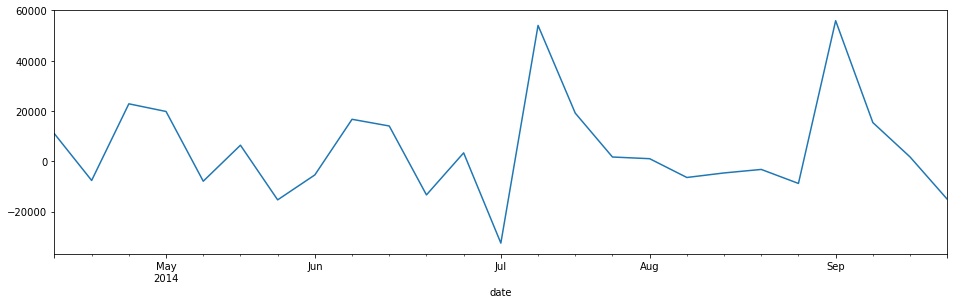

In [34]:
rides_diff = rides_weekly.diff().dropna()
_ = rides_diff.plot(figsize=(16, 4.5))

*The autocorrelation values drop-off after lag 0. This quick decrease may suggest the data are
stationary.*

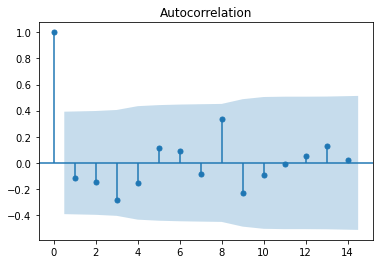

In [35]:
_ = sm.graphics.tsa.plot_acf(rides_diff)

***Remember to only pick one stationarity test.*** *For this differenced series, both the
augmented Dickey-Fuller and KPSS tests suggest the data are stationary.*

In [36]:
print(f'{"ADF":<4} p-value: {adfuller(rides_diff)[1]:.4f}')
print(f"{'KPSS':<4} p-value: {kpss(rides_diff, nlags='auto')[1]:.4f}")

ADF  p-value: 0.0000
KPSS p-value: 0.1000


C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


11. We can now identify potential ARIMA(p, d, q) models for our data, where p represents the AR
(autoregressive) order, d represents the difference order and q represents the MA (moving average)
order.

    Inspecting ACF plots can suggest an MA order and inspecting PACF plots can suggest an AR order.

    The ACF of an MA(q) process will truncate after the qth lag. The PACF of an AR(p) process will
    truncate after the pth lag.

    Use the following code to generate plots:

    ```python
    import matplotlib.pyplot as plt
    import statmodels.api as sm
    fig, axs = plt.subplots(2, sharex=True, figsize=(16, 4.5))
    sm.graphics.tsa.plot_acf(rides_diff, ax=axs[0])
    sm.graphics.tsa.plot_pacf(rides_diff, ax=axs[1], lags=11, method='ywmle')
    plt.show()
    ```

    Propose p and q based on ACF and PACF plots. Propose d (how many times was the data
    differenced?)

*The ACF plot indicates an MA order q=0. The PACF plot indicates an AR order p=0. We differenced
the data once for a difference order d=1.*  
*An ARIMA(0, 1, 0) model is known as a random walk, and
the future values of such a process cannot be predicted from past values.*

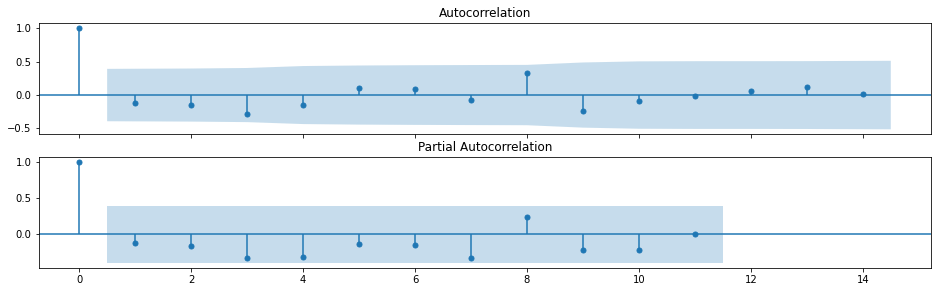

In [37]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, axs = plt.subplots(2, sharex=True, figsize=(16, 4.5))
sm.graphics.tsa.plot_acf(rides_diff, ax=axs[0])
sm.graphics.tsa.plot_pacf(rides_diff, ax=axs[1], lags=11, method='ywmle')
plt.show()

12. In converting the data to weekly rides, we lost a lot of information. We were forced to do so
because ARIMA cannot model seasonal patterns. Let's extend the ARIMA framework to model seasonal
patterns (seasonal ARIMA aka SARIMA). Instead of forecasting weekly rides, we will forecast daily rides.

    *Note: The raw data has weekly and hourly seasonality, but SARIMA can only handle one season.
    Multiple seasonality is beyond the scope of this immersive.*

    Assess the daily rides data for nonconstant variance and apply transformations as appropriate.

*A Box-Cox transformation with $\lambda$ = 0.612 is suggested (95% CI: (0.465, 0.759)). A
square-root transformation is also acceptable.*  
*We will use the transformation and standardization performed by `boxcox`.*

In [38]:
rides_daily = rides.resample('D').count()
transformed, lmbda, ci = boxcox(rides_daily, alpha=0.5)
transformed = pd.Series(transformed, index=rides_daily.index)
print(f'suggested lambda: {lmbda:.3f}')
print(f'95% CI for lambda: {tuple(round(x, 3) for x in ci)}')

suggested lambda: 0.612
95% CI for lambda: (0.465, 0.759)


13. Is the transformed data stationary? Try a stationarity test.

***Remember to only pick one stationarity test.*** *For this series, the augmented Dickey-Fuller
and KPSS tests suggest the transformed data are not stationary.*

In [39]:
print(f'{"ADF":<4} p-value: {adfuller(transformed)[1]:.4f}')
print(f"{'KPSS':<4} p-value: {kpss(transformed, nlags='auto')[1]:.4f}")

ADF  p-value: 0.8105
KPSS p-value: 0.0100


C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


14. Plot the transformed data. Is it stationary?

    *Note: Stationarity tests cannot detect violations of stationarity due to seasonality.*

*The transformed data are clearly non-stationary because of the seasonal pattern that occurs
weekly. Stationarity tests cannot detect violations of stationarity due to seasonality.*

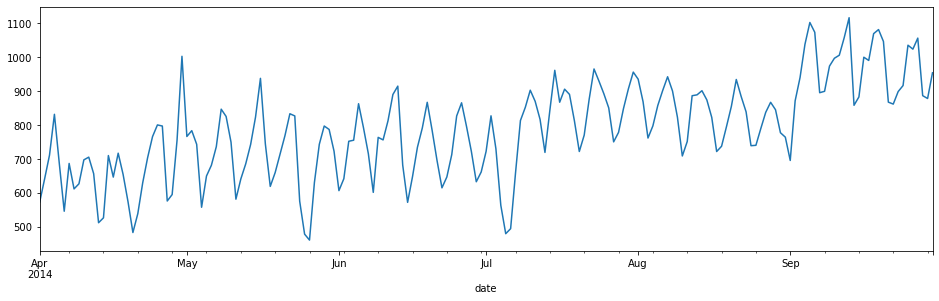

In [40]:
_ = transformed.plot(figsize=(16, 4.5))

15. Use plots, differencing and stationarity tests to make the data stationary. Use this code to
get started:

    ```python
    rides_daily = rides.resample('D').count()
    transformed, _ = boxcox(rides_daily)
    transformed = pd.Series(transformed, index=rides_daily.index)
    # Remove seasonal patterns that occur within 7 day periods.
    transformed.diff(periods=7).dropna()
    ```

    *Note: You may also detrend the data by fitting a model where the data is the target and values
    of time are the predictor. Stick to differencing for this assignment.*

*There are no apparent seasonal patterns left in the transformed and seasonally differenced data.*

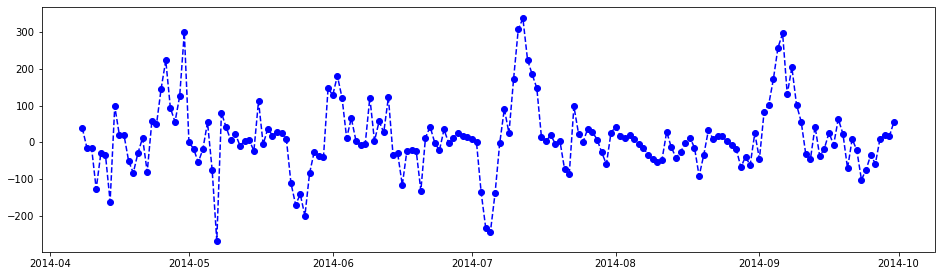

In [41]:
rides_daily = rides.resample('D').count()
transformed, lmbda = boxcox(rides_daily)
transformed = pd.Series(transformed, index=rides_daily.index)
# Remove seasonal patterns that occur within 7 day periods.
# transformed.diff(periods=7).dropna()

fig, ax = plt.subplots(figsize=(16, 4.5))
plt.plot(transformed.diff(periods=7).dropna(), 'b--')
plt.plot(transformed.diff(periods=7).dropna(), 'bo')
plt.show()

***Remember to only pick one stationarity test.*** *The transformed and seasonally differenced data
seem stationary now.*

In [42]:
print(f'{"ADF":<4} p-value: {adfuller(transformed.diff(periods=7).dropna())[1]:.4f}')
print(f"{'KPSS':<4} p-value: {kpss(transformed.diff(periods=7).dropna(), nlags='auto')[1]:.4f}")

ADF  p-value: 0.0017
KPSS p-value: 0.1000


C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


16. Make ACF and PACF plots of the stationary data.

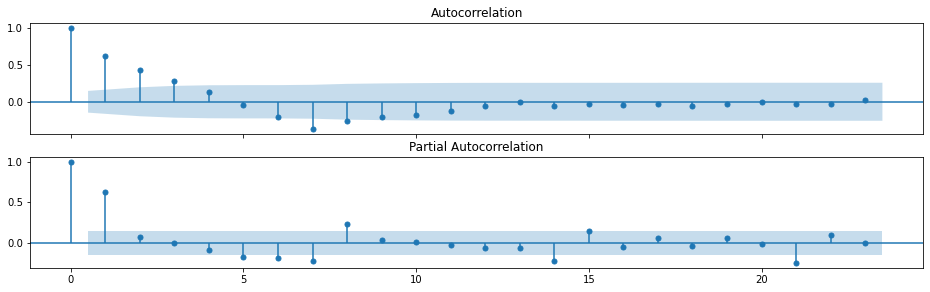

In [43]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, axs = plt.subplots(2, sharex=True, figsize=(16, 4.5))
sm.graphics.tsa.plot_acf(transformed.diff(periods=7).dropna(), ax=axs[0])
sm.graphics.tsa.plot_pacf(transformed.diff(periods=7).dropna(), ax=axs[1], method='ywmle')
plt.show()

17. The seasonal ARIMA(p, d, q)x(P, D, Q)$_m$ indicates ARIMA orders of *p*, *d* and *q*, and
season-level AR, differencing and MA orders of *P*, *D* and *Q*, respectively.  
    *m* represents the seasonal period (e.g. Monthly data across years may have a season of 12.
    Daily data may have a weekly season, or *m*=7. Hourly data may have a daily season, or *m*=24.)  
    We identified AR and MA orders *p* and *q* in ARIMA by looking for the lag where values
    abruptly drop-off.
    Similarly in SARIMA, we can identify *P*, the seasonal MA order, and *Q*, the seasonal AR order,
    by looking at lags which correspond to multiples of the period *m*, and examining the pattern
    of decay.

    Propose *P* and *Q* for a seasonal ARIMA model that fits the data. What is the value of *D*?
    What is the value of *m*?

    Also propose *p*, *d* and *q* based on the ACF and PACF plots.

*The seasonal period, m, is 7.*  
*Did we difference the data seasonally? The seasonal difference order, D, is 1.*  
*The ACF plot has a negative peak at lag 7. The seasonal MA order might be 1.*  
*The PACF plot has negative peaks at lags 7, 14 and 21 that don't decay. The seasonal AR order
might be 3. Or the peaks might be represent slow decay and so the seasonal AR order might be 0.*  
*Did we difference the data nonseasonally? The nonseasonal difference order, d, is 0.*  
*The ACF plot gradually decays across the lags. The nonseasonal MA order, p, might be 0.*  
*The PACF plot drops off after lag 1. The nonseasonal AR order, q, might be 1.*  
*A proposed model is an ARIMA(0, 0, 1)x(3, 1, 1)7.*  
*Another proposed model is an ARIMA(0, 0, 1)x(0, 1, 1)7.*

18. A few more potential SARIMA models were identified by following [this guide][5]. The
non-seasonal and seasonal orders of the model are show below in the format
`(p, d, q), (P, D, Q, m)`.

    ```python
    models = [[(0, 0, 1), (3, 1, 1, 7)],
              [(0, 0, 1), (0, 1, 1, 7)],
              [(0, 1, 1), (0, 1, 1, 7)],
              [(0, 1, 2), (0, 1, 1, 7)],
              [(1, 0, 1), (0, 1, 1, 7)],
              [(2, 0, 1), (0, 1, 1, 7)],
              [(3, 0, 1), (0, 1, 1, 7)]]
    ```

    What follows is a demonstration of how to compare various SARIMA models.

<!-- Links -->
[5]: https://people.duke.edu/~rnau/Slides_on_ARIMA_models--Robert_Nau.pdf

In [44]:
import numpy as np
# Print dictionaries in a nicer format.
import pprint
# Common model metric for forecasting.
from sklearn.metrics import mean_absolute_percentage_error
# Time series cross-validation.
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# ARIMA(p, d, q)x(P, D, Q)m orders + trend.
models = [[(0, 0, 1), (3, 1, 1, 7), 'n'],
          [(0, 0, 1), (0, 1, 1, 7), 'n'],
          [(0, 1, 1), (0, 1, 1, 7), 'n'],
          [(0, 1, 2), (0, 1, 1, 7), 'n'],
          [(1, 0, 1), (0, 1, 1, 7), 'c'],
          [(2, 0, 1), (0, 1, 1, 7), 'c'],
          [(3, 0, 1), (0, 1, 1, 7), 'c']]  # Evaluate AutoARIMA model from exercise 19.
# Record model scores.
model_scores = dict()
# `shuffle=False` splits the time series into two periods. Otherwise
# observations would be randomly selected from across the series to
# produce a test set.
# The test set is 2 weeks long because that is the forecast horizon we
# are interested in.
y_train, y_test = train_test_split(
    rides_daily, test_size=0.075, shuffle=False)
# Optimize model for forecasting the next 2 weeks (14 days).
tscv = TimeSeriesSplit(test_size=14)

for (p, d, q), (P, D, Q, m), trend in models:
    # Identify which models are producing warnings.
    # print(f'{(p, d, q)}x{(P, D, Q)}{m}')
    scores = []
    for cvtrain_i, cvtest_i in tscv.split(y_train):
        # Fit model. Powell optimizer converges better than other
        # methods.
        res = sm.tsa.statespace.SARIMAX(
            y_train[cvtrain_i], order=(p, d, q),
            seasonal_order=(P, D, Q, m),
            trend=trend).fit(method='powell', disp=False)
        # Score model.
        y_true = y_train[cvtest_i]
        mape = mean_absolute_percentage_error(
            y_true, res.predict(y_true.index[0], y_true.index[-1]))
        scores.append(mape)
    # Average and standard deviation of cross-validation scores.
    scores = np.asarray(scores)
    model_scores[f'{(p, d, q)}x{(P, D, Q)}{m}'] = [scores.mean().round(4),
                                                   scores.std().round(4)]

pprint.pprint(model_scores)

{'(0, 0, 1)x(0, 1, 1)7': [0.1512, 0.0939],
 '(0, 0, 1)x(3, 1, 1)7': [0.1552, 0.0914],
 '(0, 1, 1)x(0, 1, 1)7': [0.1081, 0.0552],
 '(0, 1, 2)x(0, 1, 1)7': [0.1235, 0.0579],
 '(1, 0, 1)x(0, 1, 1)7': [0.111, 0.0377],
 '(2, 0, 1)x(0, 1, 1)7': [0.1118, 0.0377],
 '(3, 0, 1)x(0, 1, 1)7': [0.1097, 0.0362]}


*The ARIMA(0, 1, 1)x(0, 1, 1)7 appears to be the best predictive model out of the potential models
based on MAPE. The model equation can be written explicitly as follows:*  

<div align='center'>
    <img src='../images/sarima-model-equation.png'>
</div>

<!-- *$B$ is the backshift operator, defined as: $B y_t = y_{t-1}$*    

$$
\begin{align*}
(1 - B)(1 - B^{7})y_t &= (1 - \theta_1 B)(1 - \Theta_1 B^7)e_t \\
(1 - B - B^7 + B^8)y_t &= (1 - \theta_1 B - \Theta_1 B^7 
+ \theta_1 \Theta_1 B^8)e_t \\
y_t - y_{t-1} - y_{t-7} + y_{t-8} &= e_t - \theta_1 e_{t-1}
- \Theta_1 e_{t-7} + \theta_1 \Theta_1 e_{t-8} \\
y_t &= y_{t-1} + y_{t-7} - y_{t-8} + e_t - \theta_1 e_{t-1}
- \Theta_1 e_{t-7} + \theta_1 \Theta_1 e_{t-8} \\
y_t &= y_{t-1} + y_{t-7} - y_{t-8} + e_t - 0.3306 e_{t-1}
- 0.8842 e_{t-7} + (-0.3306)*(-0.8842) e_{t-8}
\end{align*}
$$

$$
y_t = y_{t-1} + y_{t-7} - y_{t-8} + e_t - 0.3306 e_{t-1}
- 0.8842 e_{t-7} + 0.2923 e_{t-8}
$$ -->

*We can investigate the model diagnostics to evaluate the quality of forecast intervals.*  
*The Ljung-Box p-value=0.63, so there is not enough evidence to conclude that the model residuals
are correlated. The residuals appear uncorrelated (lower right plot) so there is no leftover
structure to add to our model.*  

*The heteroskedascity test p-value=0.06, so there is not enough evidence to conclude that the
variation of the residuals is different between the beginning and end of the data series (upper
left plot). This is good for our forecast interval.*  

*The Jarque-Bera test p-value=0.00, so there is evidence that the residuals do not follow a Normal
distribution (top right and bottom left plot). This is bad for our forecast interval.*  

*These statistical test results suggest that automatically generated forecast intervals and
the default statistical significance tests of the model coefficients will not be accurate, but the
model will still be useful for predicting mean trends.*  
*You can use bootstrapping to generate intervals, but you will have to implement it on your own.*

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  169
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1527.969
Date:                           Mon, 29 Mar 2021   AIC                           3061.938
Time:                                   12:15:30   BIC                           3071.183
Sample:                               04-01-2014   HQIC                          3065.692
                                    - 09-16-2014                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3306      0.051     -6.516      0.000      -0.430      -0.231
ma.S.L7       -0.8842      0.072    -12.214      0.000      -1.026      -0.742
sigma2      9.828e+06   7.89e+05     12.458      0.000    8.28e+06    1.14e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                35.03
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.15
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

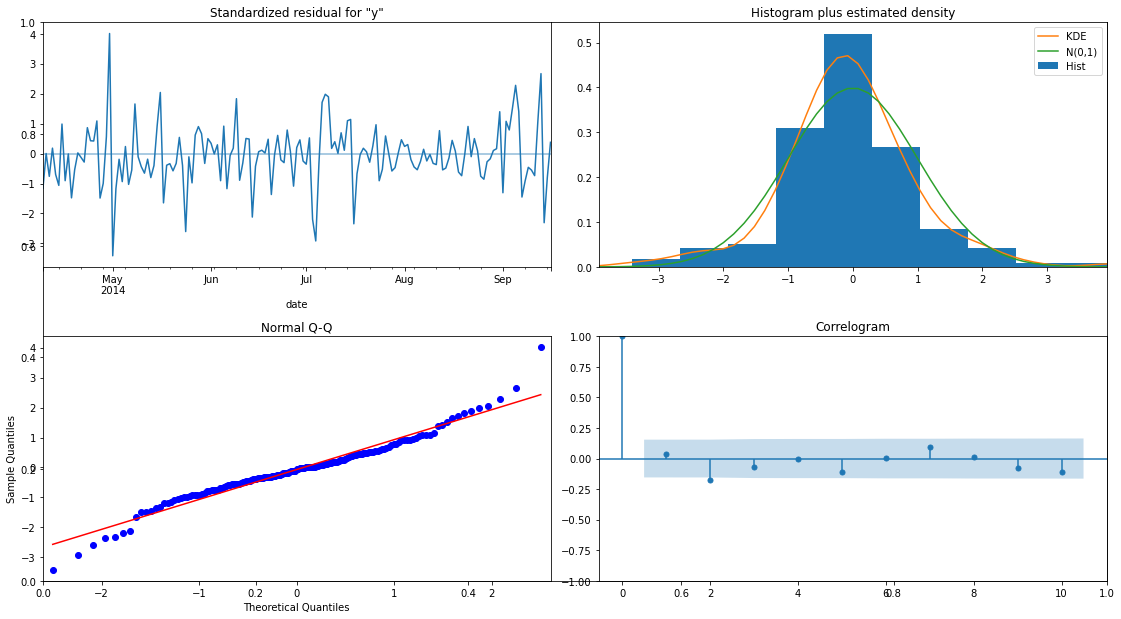

In [45]:
# Investigate diagnostics of selected model.

from IPython.display import display

res = sm.tsa.statespace.SARIMAX(
    y_train, order=(0, 1, 1),
    seasonal_order=(0, 1, 1, 7)).fit(method='powell', disp=False)
display(res.summary())

fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)
res.plot_diagnostics(fig=fig)
plt.show()

*The model predicts the end of September well.*  
*If you investigate other models, you will find that this model has relatively large confidence
intervals, so there is a lot of uncertainty in the forecast.*  
*The model achieves an MAPE of 10.2% on the test set, which is similar to the cross-validation
performance of 10.8%.*

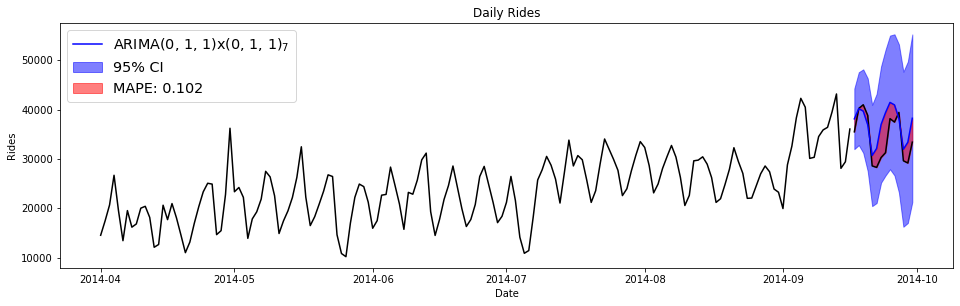

In [46]:
# Plot prediction performance on test set.
# The confidence intervals are inaccurate because the assumptions
# underlying their equations were not satisfied.
# You can use bootstrapping to generate intervals, but you will have to
# implement it on your own.
predict = res.get_prediction(y_test.index[0], y_test.index[-1])
predict_ci = predict.conf_int()
mape = mean_absolute_percentage_error(y_test, predict.predicted_mean)

fig, ax = plt.subplots(figsize=(16, 4.5))
ax.plot(y_train, 'k')
ax.plot(y_test, 'k')
ax.plot(predict.predicted_mean, 'b',
        label='ARIMA(0, 1, 1)x(0, 1, 1)$_7$')
ax.fill_between(
    predict_ci.index, predict_ci['lower y'], predict_ci['upper y'],
    alpha=0.5, color='b', label='95% CI')
ax.fill_between(
    predict_ci.index, predict.predicted_mean, y_test,
    alpha=0.5, color='r', label=f'MAPE: {mape:.3f}')
ax.set(title='Daily Rides', xlabel='Date', ylabel='Rides')
ax.legend(loc='upper left', fontsize='x-large')
plt.show()

19. R users will be familiar with the `auto.arima` function in the R `forecast` package, which searches for a combination of ARIMA parameters that produces good predictive models based on a stepwise-algorithm ([Hyndman & Khandakar, 2008][6]).

    The Python `pmdarima` library ([installation instructions][7]) is actively maintained* (as of 2021) and emulates the functionality of `auto.arima`.  What follows is a demonstration of the library.

    *Warning: Become dependent on small open-source projects at [your own risk][8].

<!-- Links -->
[6]: https://cran.r-project.org/web/packages/forecast/vignettes/JSS2008.pdf
[7]: http://alkaline-ml.com/pmdarima/setup.html#setup
[8]: https://xkcd.com/2347/

*The ARIMA(1, 1, 2)x(1, 0, 1)7 model has the lowest AIC (Akaike information criterion, a common
model metric for statistical regression models) of the models explored by the AutoARIMA algorithm.*  

***AutoARIMA allows us to quickly evaluate a large number of models, but we may be able to produce a
better model using our expertise if we spend more time on the problem. This is the trade-off of
using automatic methods.***

*The model equation can be written explicitly and if you go through the long algebra, you may find
that this model is very similar to the one we manually crafted, with additional lagged terms that
have negligible coefficients. Different combinations of order values can yield models with similar point predictions that differ in their forecast intervals.*  

*We can investigate the model diagnostics to evaluate the quality of forecast intervals.*  
*The Ljung-Box p-value=0.53, so there is not enough evidence to conclude that the model residuals
are correlated. The residuals appear uncorrelated (lower right plot) so there is no leftover
structure to add to our model.*  

*The heteroskedascity test p-value=0.01, so there is evidence that the variation of the residuals
is different between the beginning and end of the data series (upper left plot). This is bad for
our forecast interval.*  

*The Jarque-Bera test p-value=0.00, so there is evidence that the residuals do not follow a Normal
distribution (top right and bottom left plot). This is bad for our forecast interval.*  

*The highest order nonseasonal MA coefficient is not statistically significant with a p-value=0.98.
The p-value is inaccurate as indicated by the results of the tests above but ignoring that,
including non-significant terms is not a problem for prediction, but we may want to remove such
terms as part of the process of improving the forecast interval (distributional forecast.)*  

*These statistical test results suggest that automatically generated forecast intervals and
the default statistical significance tests of the model coefficients will not be accurate, but the
model will still be useful for predicting mean trends.*  
*You can use bootstrapping to generate intervals, but you will have to implement it on your own.*

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  169
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -1593.942
Date:                             Mon, 29 Mar 2021   AIC                           3199.883
Time:                                     12:16:11   BIC                           3218.627
Sample:                                          0   HQIC                          3207.490
                                             - 169                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6584      0.135      4.888      0.000       0.394       0.922
ma.L1         -0.9651      0.168     -5.730      0.000      -1.295      -0.635
ma.L2         -0.0024      0.159     -0.015      0.988      -0.314       0.309
ar.S.L7        0.9965      0.007    142.092      0.000       0.983       1.010
ma.S.L7       -0.9296      0.073    -12.802      0.000      -1.072      -0.787
sigma2       9.44e+06   1.48e-08   6.39e+14      0.000    9.44e+06    9.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                48.57
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.74e+30. Standard errors may be unstable.
"""

C:\Users\K\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


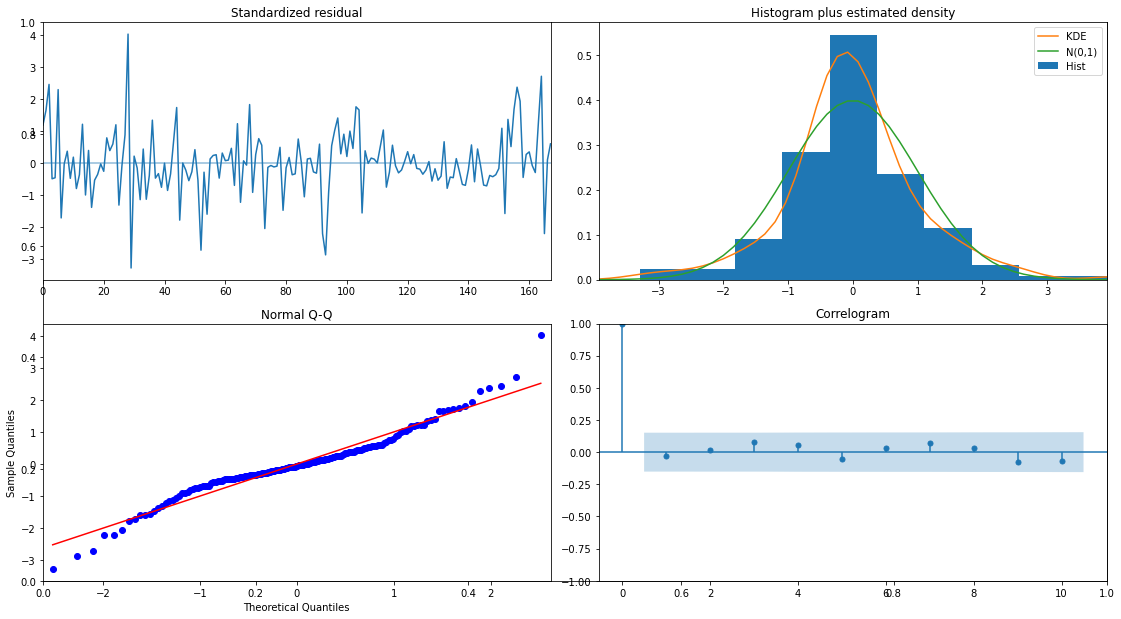

In [47]:
from IPython.display import display
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.model_selection import train_test_split

y_train, y_test = train_test_split(rides_daily, test_size=0.075)
# We observed strong seasonality in the data, but the `AutoARIMA`
# algorithm does not select a model with seasonal differencing.
# However, different combinations of ARIMA orders can lead to similar
# models when the model formula are written out and simplified.
res = pm.AutoARIMA(m=7, seasonal=True).fit(y_train)
display(res.summary())

# AutoARIMA does not have a plot_diagnostics method, so we fit the same
# final model using ARIMA. lbfgs optimization method does not converge
# so we use powell's method.
res = pm.ARIMA(order=(1, 1, 2), seasonal_order=(1, 0, 1, 7),
               method='powell').fit(y_train)

fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)
res.plot_diagnostics(fig=fig)
plt.show()

*The model predicts the end of September better than our manually crafted model, with less
uncertainty (narrower forecast intervals.)*  
*The model achieves an MAPE of 9.1% on the test set.*

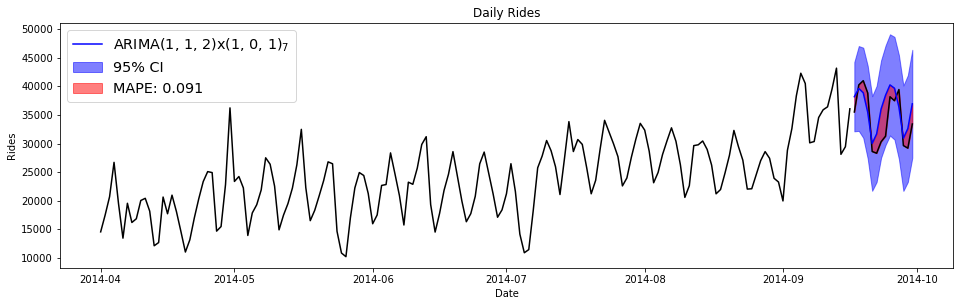

In [48]:
# Plot prediction performance on test set.
# The confidence intervals are inaccurate because the assumptions
# underlying their equations were not satisfied.
# You can use bootstrapping to generate intervals, but you will have to
# implement it on your own.
preds, conf_int = res.predict(len(y_test), return_conf_int=True)
mape = mean_absolute_percentage_error(y_test, preds)

fig, ax = plt.subplots(figsize=(16, 4.5))
ax.plot(y_train, 'k')
ax.plot(y_test, 'k')
ax.plot(y_test.index, preds, 'b',
        label='ARIMA(1, 1, 2)x(1, 0, 1)$_7$')
ax.fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1],
                alpha=0.5, color='b', label='95% CI')
ax.fill_between(y_test.index, preds, y_test, alpha=0.5, color='r',
                label=f'MAPE: {mape:.3f}')
ax.set(title='Daily Rides', xlabel='Date', ylabel='Rides')
ax.legend(fontsize='x-large')
plt.show()

## Extra Credit
### Part 3: LAPD Calls For Service

1. Using data about LAPD calls for service between 2010-2020, use ARIMA models to predict the total
number of calls for the following periods:
    - First 2 weeks of July 2020 (July 1 - 14)
    - Month of July 2020

    Identify at least two prediction models before choosing a final model, and plot your fitted
    model with predictions overlaid on the raw data.

    You can run the `make_lapd.py` script in `src/` to clean and concatenate the yearly calls
    files. Here are a few ways to do so:
    ```console
    # 1. Navigate to time-series-arima/src and run the following from
    # the console.
    python make_lapd.py --dir_data ../data/raw/lapd --dir_out ../data

    # Or
    # 2. Navigate to time-series-arima/data and run the following from
    # the console.
    python ../src/make_lapd.py --dir_data raw/lapd

    # etc.
    ```

    If the resulting file is too large to work with, just work with 2020 data in `data/raw/lapd`.